# Strategy

- Classifier of OCR (Optical Character Recognition) recognizing pose as character

# Import Libraries

In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
tf.random.set_seed(0)
from keras import utils
from keras import Sequential
from keras import layers
from keras import backend
from keras import optimizers

# Mount Drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Clone Repository

In [3]:
%cd "/content/drive/My Drive"
if not os.path.exists('yogapose-classification-ocr'):
  !git clone https://github.com/AkienMain/yogapose-classification-ocr.git

/content/drive/My Drive
Cloning into 'yogapose-classification-ocr'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 2), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 1.55 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# Import dataset

In [4]:
%cd "/content/drive/My Drive/yogapose-classification-ocr"

# Display all columns
pd.options.display.max_columns = 100

# Import
df = pd.read_csv('dataset.csv', index_col=0)
df.head()

/content/drive/My Drive/yogapose-classification-ocr


,NOSE_x,NOSE_y,LEFT_SHOULDER_x,LEFT_SHOULDER_y,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,LEFT_ELBOW_x,LEFT_ELBOW_y,RIGHT_ELBOW_x,RIGHT_ELBOW_y,LEFT_WRIST_x,LEFT_WRIST_y,RIGHT_WRIST_x,RIGHT_WRIST_y,LEFT_INDEX_x,LEFT_INDEX_y,RIGHT_INDEX_x,RIGHT_INDEX_y,LEFT_HIP_x,LEFT_HIP_y,RIGHT_HIP_x,RIGHT_HIP_y,LEFT_KNEE_x,LEFT_KNEE_y,RIGHT_KNEE_x,RIGHT_KNEE_y,LEFT_ANKLE_x,LEFT_ANKLE_y,RIGHT_ANKLE_x,RIGHT_ANKLE_y,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,CENTER_HIP_x,CENTER_HIP_y,CENTER_SHOULDER_x,CENTER_SHOULDER_y,Angle_upper_arms,Angle_elbow_L,Angle_elbow_R,Angle_thighs,Angle_knee_L,Angle_knee_R,Angle_shoulder_L,Angle_shoulder_R,Angle_hip_L,Angle_hip_R,width,height,pose_num
0,1589.38,1370.77,1793.95,1310.91,1786.62,1731.39,1805.85,1012.54,1776.60,2062.86,1778.22,715.51,1727.70,2364.44,1761.52,617.47,1694.14,2453.85,2411.77,1380.54,2366.87,1578.59,2913.98,1415.45,2380.98,2035.24,3379.55,1443.17,2334.87,2534.42,3502.44,1422.20,2150.48,2633.84,2389.32,1479.57,1790.29,1521.15,179.45,7.60,7.48,84.25,0.57,7.05,83.75,95.70,7.95,92.20,4496,3000,0
1,1629.62,654.00,1494.16,806.80,1525.09,596.89,1490.09,943.40,1503.74,452.75,1489.79,1089.12,1524.45,303.22,1508.89,1125.58,1546.96,256.67,1242.96,667.36,1240.00,550.27,1217.54,863.82,990.81,540.13,1230.68,1091.31,781.30,524.51,1322.90,1127.86,706.31,519.18,1241.48,608.81,1509.63,701.85,169.87,1.59,16.31,84.96,10.67,1.93,107.43,62.44,101.76,16.80,2400,1350,0
2,581.32,607.65,702.21,549.52,711.01,770.38,720.43,372.66,719.98,956.67,724.72,216.15,716.05,1119.25,722.04,163.88,705.62,1170.13,1025.55,512.39,1016.44,632.03,1318.25,517.59,1037.22,885.59,1577.96,512.25,1009.99,1145.82,1696.94,513.53,911.49,1207.09,1020.99,572.21,706.61,659.95,171.36,4.31,4.14,84.30,2.20,10.66,68.53,102.83,16.61,100.91,2000,1334,0
3,183.60,492.73,241.68,443.16,250.24,566.01,261.24,349.26,257.15,662.37,255.47,253.72,234.07,759.63,248.37,222.14,216.32,785.17,421.40,422.67,413.59,485.34,566.31,380.61,432.50,626.48,698.10,349.73,428.22,766.07,770.38,363.19,371.89,804.23,417.49,454.01,245.96,504.59,164.13,15.23,17.45,98.55,3.00,9.39,61.80,102.33,0.25,98.80,910,910,0
4,75.79,80.09,93.94,71.82,95.85,103.72,95.77,49.40,97.87,127.82,91.30,30.07,96.54,150.42,89.52,23.54,94.43,156.84,139.16,67.75,138.83,85.48,173.73,56.45,143.25,119.22,205.21,44.87,142.46,154.41,218.17,38.81,127.17,162.97,138.99,76.62,94.89,87.77,170.54,17.67,8.18,100.64,2.11,8.74,71.14,99.40,3.90,96.74,283,178,0


# Calculate values

- Relative position
- Bounding box
- Bounding box (square)

In [5]:
# Columns list
cols_x = df.columns[df.columns.str.contains('_x')]
cols_y = df.columns[df.columns.str.contains('_y')]
cols_A = df.columns[df.columns.str.contains('Angle_')]

# bounding box (left, right, top, bottom)
df['bb_l'] = df.loc[:, cols_x].min(axis=1)
df['bb_r'] = df.loc[:, cols_x].max(axis=1)
df['bb_t'] = df.loc[:, cols_y].min(axis=1)
df['bb_b'] = df.loc[:, cols_y].max(axis=1)

# center x, center y, distance from center
cx = (df['bb_r'] + df['bb_l']) / 2
cy = (df['bb_b'] + df['bb_t']) / 2
d = np.maximum(df['bb_r']-df['bb_l'], df['bb_b']-df['bb_t']) / 2

# bounding box square (left, right, top, bottom)
df['bbsq_l'] = cx-d
df['bbsq_r'] = cx+d
df['bbsq_t'] = cy-d
df['bbsq_b'] = cy+d

# relative position (normalization)
for c in cols_x:
  # normalization (0-1)
  series = (df.loc[:,c]-df.loc[:,'bbsq_l']) / (df.loc[:,'bbsq_r']-df.loc[:,'bbsq_l'])
  # translate (0.1-0.9) to set padding
  df.loc[:,f'{c}_rel'] = series * 0.8 + 0.1

for c in cols_y:
  # normalization (0-1)
  series = (df.loc[:,c]-df.loc[:,'bbsq_t']) / (df.loc[:,'bbsq_b']-df.loc[:,'bbsq_t'])
  # translate (0.1-0.9) to set padding
  df.loc[:,f'{c}_rel'] = series * 0.8 + 0.1

# Columns list
cols_rel = df.columns[df.columns.str.contains('_rel')]


# Create Image for OCR (Optical Character Recognition)

In [6]:
# Definition of lines for image
line_groups = [
  [
    'NOSE',
    'CENTER_SHOULDER',
    'LEFT_SHOULDER',
    'LEFT_HIP',
    'RIGHT_HIP',
    'RIGHT_SHOULDER',
    'CENTER_SHOULDER',
    'NOSE',
  ], [
    'LEFT_SHOULDER',
    'LEFT_ELBOW',
    'LEFT_WRIST',
    'LEFT_INDEX'
  ], [
    'RIGHT_SHOULDER',
    'RIGHT_ELBOW',
    'RIGHT_WRIST',
    'RIGHT_INDEX'
  ], [
    'LEFT_HIP',
    'LEFT_KNEE',
    'LEFT_ANKLE',
    'LEFT_FOOT_INDEX'
  ], [
    'RIGHT_HIP',
    'RIGHT_KNEE',
    'RIGHT_ANKLE',
    'RIGHT_FOOT_INDEX'
  ]
]

# Definition of polygons for image
polygon_groups = [
  [
    'NOSE',
    'CENTER_SHOULDER',
    'LEFT_SHOULDER',
    'LEFT_HIP',
    'RIGHT_HIP',
    'RIGHT_SHOULDER',
    'CENTER_SHOULDER',
    'NOSE',
  ]
]

image_folder = 'stick_image'
image_size = 64
thickness=2

# Create folder
if not os.path.exists(image_folder):
  os.makedirs(image_folder)
  print(f'{image_folder} (folder) is created!')

for index in df.index:

  # Initialize image
  img = np.zeros((image_size, image_size))

  # Draw line
  for line_group in line_groups:
    for i in range(len(line_group)-1):
      p_from = (int(df.loc[index,f'{line_group[i]}_x_rel']*image_size),
                int(df.loc[index,f'{line_group[i]}_y_rel']*image_size))
      p_to = (int(df.loc[index,f'{line_group[i+1]}_x_rel']*image_size),
              int(df.loc[index,f'{line_group[i+1]}_y_rel']*image_size))
      cv2.line(img, p_from, p_to, (255), thickness=thickness)

  # Draw polygon
  points = np.array([])
  for polygon_group in polygon_groups:
    for joint in polygon_group:
      points = np.append(points, [df.loc[index,f'{joint}_x_rel']*image_size,
                                  df.loc[index,f'{joint}_y_rel']*image_size])
  if points.size > 0:
    points = np.reshape(points, (-1,2)).astype(int)
    cv2.fillPoly(img, [points], (255))

  # Write image
  cv2.imwrite(f'{image_folder}/{index:03}.png', img)

stick_image (folder) is created!


# Check
- Absolute positions
- Relative positions
- Image

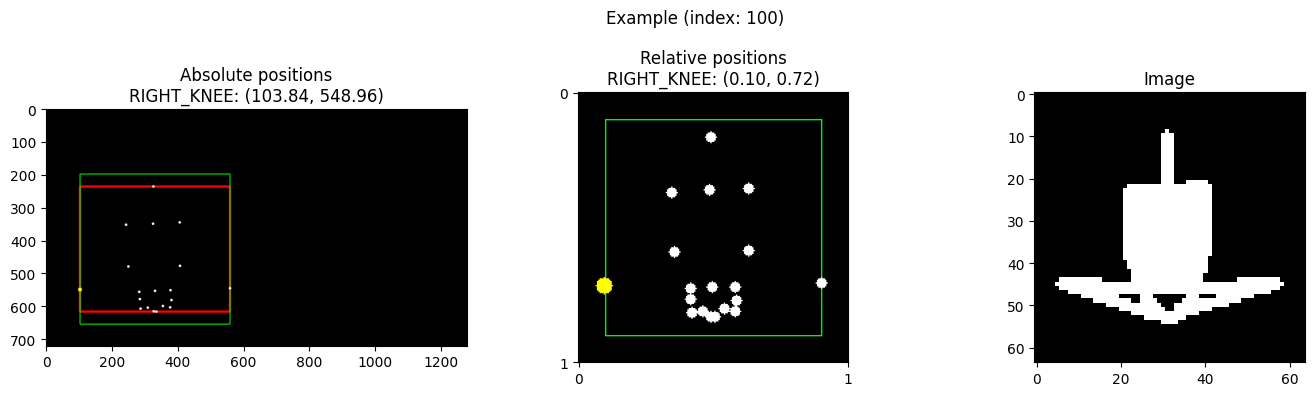

In [7]:
index = 100

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

bb_l = int(df.loc[index,'bb_l'])
bb_r = int(df.loc[index,'bb_r'])
bb_t = int(df.loc[index,'bb_t'])
bb_b = int(df.loc[index,'bb_b'])
bbsq_l = int(df.loc[index,'bbsq_l'])
bbsq_r = int(df.loc[index,'bbsq_r'])
bbsq_t = int(df.loc[index,'bbsq_t'])
bbsq_b = int(df.loc[index,'bbsq_b'])

# key points
key_points = [
  'NOSE',
  'LEFT_SHOULDER',
  'RIGHT_SHOULDER',
  'LEFT_ELBOW',
  'RIGHT_ELBOW',
  'LEFT_WRIST',
  'RIGHT_WRIST',
  'LEFT_INDEX',
  'RIGHT_INDEX',
  'LEFT_HIP',
  'RIGHT_HIP',
  'LEFT_KNEE',
  'RIGHT_KNEE',
  'LEFT_ANKLE',
  'RIGHT_ANKLE',
  'LEFT_FOOT_INDEX',
  'RIGHT_FOOT_INDEX',
  'CENTER_HIP',
  'CENTER_SHOULDER'
]

# Example point
example_point = 'RIGHT_KNEE'

################

img1 = np.zeros((df.loc[index,'height'], df.loc[index,'width'], 3))
img1 = cv2.rectangle(img1, (bb_l, bb_t), (bb_r, bb_b), color=(255,0,0), thickness=6)
img1 = cv2.rectangle(img1, (bbsq_l, bbsq_t), (bbsq_r, bbsq_b), color=(0,255,0), thickness=2)

for kp in key_points:
  c = (255,255,0) if (kp == example_point) else (255,255,255)
  r = 6 if (kp == example_point) else 4
  x = int(df.loc[index, f'{kp}_x'])
  y = int(df.loc[index, f'{kp}_y'])
  img1 = cv2.circle(img1, (x, y), radius=r, color=c, thickness=-1)

axs[0].imshow(img1)
axs[0].set_title(f"Absolute positions\n{example_point}: ({df.loc[index, f'{example_point}_x']:.2f}, {df.loc[index, f'{example_point}_y']:.2f})")

################

length = 200

img2 = np.zeros((length, length, 3))
img2 = cv2.rectangle(img2, (int(length*0.1),int(length*0.1)), (int(length*0.9),int(length*0.9)), color=(0,255,0), thickness=1)

for kp in key_points:
  c = (255,255,0) if (kp == example_point) else (255,255,255)
  r = int(length/30) if (kp == example_point) else int(length/50)
  x = int(df.loc[index, f'{kp}_x_rel']*length)
  y = int(df.loc[index, f'{kp}_y_rel']*length)
  img2 = cv2.circle(img2, (x, y), radius=r, color=c, thickness=-1)

axs[1].imshow(img2)
axs[1].set_xticks([0,length])
axs[1].set_yticks([0,length])
axs[1].set_xticklabels([0,1])
axs[1].set_yticklabels([0,1])
axs[1].set_title(f"Relative positions\n{example_point}: ({df.loc[index, f'{example_point}_x_rel']:.2f}, {df.loc[index, f'{example_point}_y_rel']:.2f})")

################

filename = f'stick_image/{index}.png'
img3 = cv2.imread(filename)
axs[2].imshow(img3)
axs[2].set_title('Image')

################

fig.suptitle(f'Example (index: {index})')
fig.tight_layout()

# Check images (all poses)

Indeces: [0, 59, 119, 179, 239, 299, 365, 425]


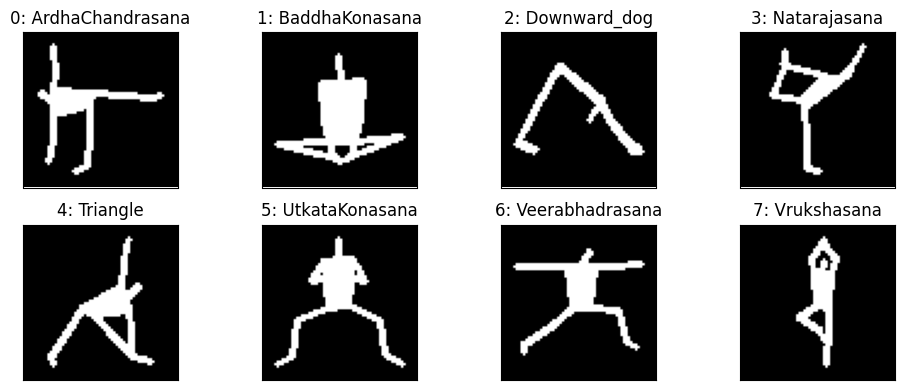

In [8]:
# Indices of example of each pose
indices = []
n = -1
for i in df.index:
  if n != df.loc[i,'pose_num']:
    indices.append(i)
    n = df.loc[i,'pose_num']
print(f'Indeces: {indices}')

# Yoga pose name
posename_dic = {
  0: 'ArdhaChandrasana',
  1: 'BaddhaKonasana',
  2: 'Downward_dog',
  3: 'Natarajasana',
  4: 'Triangle',
  5: 'UtkataKonasana',
  6: 'Veerabhadrasana',
  7: 'Vrukshasana'
}

fig, axs = plt.subplots(2, int(len(indices)/2), figsize=(10, 4))

for i in range(len(indices)):
  filename = f'stick_image/{indices[i]:03}.png'
  im = cv2.imread(filename)
  axs[i//4, i%4].imshow(im)
  axs[i//4, i%4].set_title(f'{i}: {posename_dic[i]}')
  axs[i//4, i%4].set_xticks([])
  axs[i//4, i%4].set_yticks([])
fig.tight_layout()


# Split Data

In [9]:
# y (response variable)

y = df['pose_num']

y_train, y_test = train_test_split(y, test_size=0.3, random_state=42)

y_train_category = utils.to_categorical(y_train)
y_test_category = utils.to_categorical(y_test)

# X (explanatory variables)

ims = np.empty([len(df.index), image_size*image_size])
for i in df.index:
  ims[i,:] = cv2.imread(f'{image_folder}/{i:03}.png', cv2.IMREAD_UNCHANGED).flatten()
ims_df = pd.DataFrame(ims)

X_train = ims_df.loc[y_train.index,:].to_numpy()
X_test = ims_df.loc[y_test.index,:].to_numpy()

X_train = X_train.reshape(len(y_train.index),image_size,image_size)
X_test = X_test.reshape(len(y_test.index),image_size,image_size)


print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train_category.shape: {y_train_category.shape}')
print(f'y_test_category.shape: {y_test_category.shape}')

X_train.shape: (338, 64, 64)
X_test.shape: (145, 64, 64)
y_train_category.shape: (338, 8)
y_test_category.shape: (145, 8)


# OCR Model

Convolutional Neural Network

In [10]:
# Create model

backend.clear_session()
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(image_size, image_size, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.name = 'CNN_0'
model.layers[0].name = 'Conv_0'
model.layers[1].name = 'Pool_0'
model.layers[2].name = 'Conv_1'
model.layers[3].name = 'Pool_1'
model.layers[4].name = 'Conv_2'
model.layers[5].name = 'Pool_2'
model.layers[6].name = 'Flatten_0'
model.layers[7].name = 'Dense_0'
model.layers[8].name = 'Dense_1'

model.compile(optimizer=optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_0 (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_0 (MaxPooling2D)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_1 (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_2 (MaxPooling2D)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_0 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_0 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,544 (2.36 MB)

 Trainable params: 617,544 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train model
model.fit(X_train, y_train_category, epochs=10, batch_size=8)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5870 - loss: 6.0347
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9491 - loss: 0.1990
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9627 - loss: 0.1876
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9824 - loss: 0.1445
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9990 - loss: 0.0116
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9984 - loss: 0.0635
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9969 - loss: 0.0521
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 1.0000 - loss: 0.0047
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 1.0000 - loss: 5.7530e-05
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 1.2181e-08


In [12]:
# Calculate accuracy
def calc_acc(pred, test):
  acc = (pred==test).sum()/pred.shape[0]
  print(f'Accuracy : {acc:.3}')
  return acc

# Show result
def show_result(pred, test):

  fig, axs = plt.subplots(1, 1, figsize=(4, 4))
  axs.plot(test, pred, linestyle='None', marker='o', alpha=0.2, markersize=12)
  axs.plot([-1,8], [-1,8], linestyle='--', color='k', label='Actual = Predicted')
  axs.set_xlabel('Actual')
  axs.set_ylabel('Predicted')
  axs.set_xticks(np.arange(8))
  axs.set_yticks(np.arange(8))
  axs.set_yticklabels(posename_dic.items())

  fig, axs = plt.subplots(2, 4, figsize=(10, 4))
  for i in range(8):
    y_pred_i = pred[test==i]
    acc = (y_pred_i==i).sum()/y_pred_i.shape[0]
    axs[i//4,i%4].hist(y_pred_i, bins=np.arange(9)-0.5)
    axs[i//4,i%4].set_xticks(np.arange(8))
    axs[i//4,i%4].set_title(f'Actual:{i}, acc:{acc:.2}')
  fig.tight_layout()

# Accuracy with Training Data

***Train data***
Accuracy : 1.0


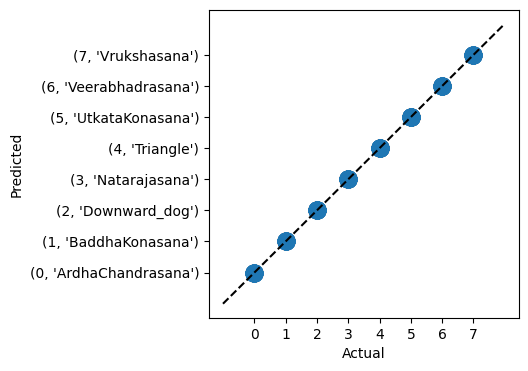

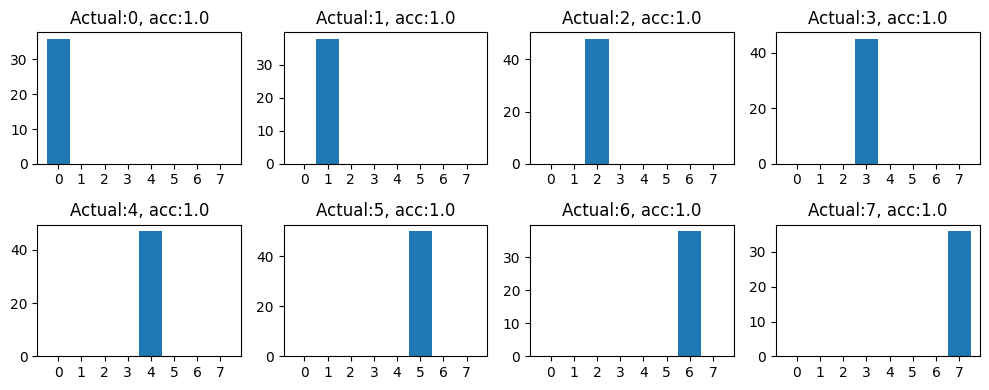

In [13]:
# Validate accuracy with training data
print('***Train data***')
y_trainpred_prob = model.predict(X_train, verbose=0)
y_trainpred = np.argmax(y_trainpred_prob, axis=1)
acc_trainpred = calc_acc(y_trainpred, y_train)

show_result(y_trainpred, y_train)

# Results: Accuracy with Test Data

***Test data***
Accuracy : 1.0


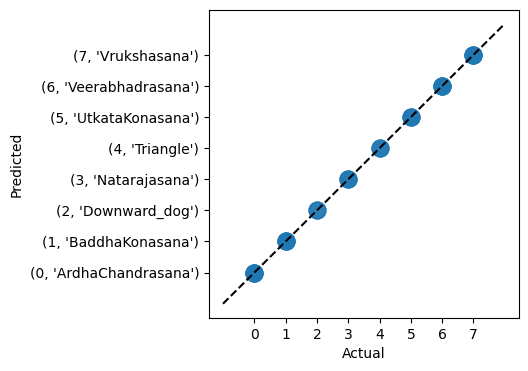

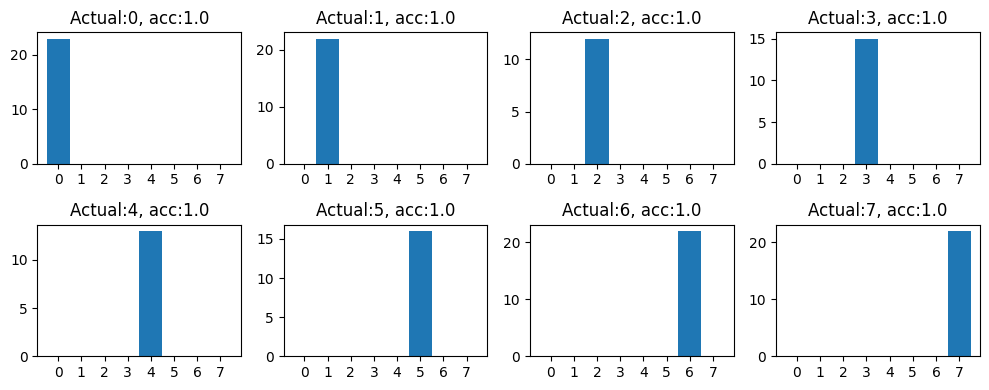

In [14]:
print('***Test data***')
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
acc_pred = calc_acc(y_pred, y_test)

show_result(y_pred, y_test)